Notebook contains **hard-margin svm** manual solution using lagrangian dual as well as **Perceptron Algorithm** implementation

In [22]:
%run -m ipy_startup
%matplotlib inline

In [2]:
from sklearn.svm import SVC

# Scikit Learn Solution

To SVM hard margin problem

Visualizing hyperplane: http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html

In [177]:
X = [
    [-1, -1],
    [0, 1],
    [1, -2],
    [1, 2]
]
y = [-1, 1, -1, 1]
X, y = np.array(X), np.array(y)
X, y

(array([[-1, -1],
        [ 0,  1],
        [ 1, -2],
        [ 1,  2]]), array([-1,  1, -1,  1]))

In [178]:
m = SVC(kernel='linear', degree=1, C=np.inf, shrinking=False)
m.fit(X, y)

SVC(C=inf, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=1, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=False,
  tol=0.001, verbose=False)

In [183]:
# These are values of parameters for weight vector that is normal
# to separating hyperplane (i.e. a line in 2D)
m.intercept_, m.coef_

(array([ 0.2]), array([[ 0.4,  0.8]]))

In [184]:
# Presmuably these are all the non-zero lagrange multipliers though
# I'm not sure why they're ever negative
m.dual_coef_

array([[-0.4,  0.4]])

In [185]:
# Obvious 
m.support_vectors_

array([[-1., -1.],
       [ 0.,  1.]])

In [186]:
m.support_

array([0, 1], dtype=int32)

In [208]:
# w = clf.coef_[0]
# a = -w[0] / w[1]
# xx = np.linspace(-5, 5)
# yy = a * xx - (clf.intercept_[0]) / w[1]

# To get the separating line, you first have to find an equation for the line
# normal to the weight vector w (which has slope equal to negative reciprocal)
w = m.coef_[0]
s = -w[0]/w[1]
b = - m.intercept_[0] / w[1]
xl = np.linspace(-2, 2, num=100)
yl = s * xl + b

In [210]:
s, b

(-0.49999999999999994, -0.24999999999999989)

In [190]:
# ax + by + c = 0
# => a =-s, b=1, c=-b
def get_dist(slope, intercept, p):
    """ Find smallest distance from `p` to line given by `slope` and `intercept`"""
    return (-slope*p[0] + p[1] - intercept) / np.sqrt(slope**2 + 1)

for p in X:
    print(p, 'dist = ', get_dist(s, b, p))

[-1 -1] dist =  [-1.11803399]
[0 1] dist =  [ 1.11803399]
[ 1 -2] dist =  [-1.11803399]
[1 2] dist =  [ 2.45967478]


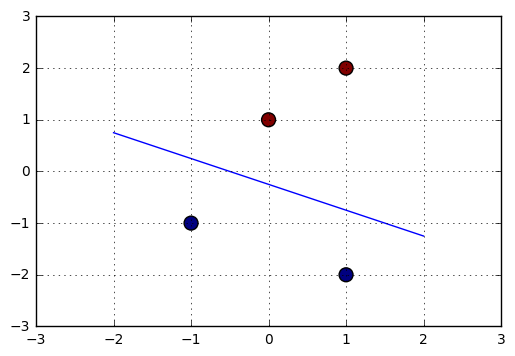

In [191]:
plt.scatter(x=X[:,0], y=X[:,1], c=y, s=100)
plt.plot(xl, yl)
plt.grid()

# Direct Optimization

### Dual Lagrangian

In [202]:
import numpy as np
from scipy.optimize import minimize



def dual_lagrangian_max_margin(X, y):
    """ Solves for lagrangian weights in dual formulation for max-margin classification 
    
    Note that this formulation is found by:
    1. Expressing the primal formulation in terms of the weights for the hyperplane and 
        the lagrange multipliers times the constraints that make that hyperplane separating.
            - The constraints are all >= 0 inequalities like 1 - y(w*x + b) >= 0
            - The number of constraints is equal to number of data points (n), thus the number 
                of lagrange multipliers is also n
    2. Differentiating primal by w and b, setting to 0, and then plugging those answers back
        into the original observation problem.  These will come out as:
            - w = sum(ai * yi * xi) over all i [where ai is lagrange multiplier i]
            - b = not defined in solution for maximum value, though this differentiation does
                give the important "balance" constraint (that sum(ai * yi) over all i = 0)
    3. Those values placed back in the primal expression give the dual formulation with the
        following constraints:
            - sum(ai * yi) over all i = 0
            - ai >= 0 for all i
    4. And the dual lagrangian objective function is: 
            - L(a) = sum(ai) - 1/2 * sum(pairwise points[xi, xj] {ai aj yi yj <xi, xj>})
            
    This function will maximize the above function with respect to the lagrange multipliers ai
    and return the optimization result (which will contain those weights)
    
    :param X: data matrix (n,p)
    :param y: response array (n,) in {-1, 1}
    :return scipy optimize result
    """
    n = X.shape[0]
    
    def loss(w):
        assert len(w) == n
        
        # Compute right half of L
        l = 0
        for i in range(n):
            for j in range(n):
                l += y[i]*y[j]*w[i]*w[j]*np.dot(X[i], X[j])
                
        # Add to left half of L
        #L = np.sum(w) - .5 * l
        
        w1, w2, w3, w4 = w
        L = np.sum(w) - (w1**2 + w1*w2 + w1*w3 + 3*w1*w4 + .5*w2*w2 + 2*w2*w3 + 2*w2*w4 + 2.5*w3*w3 + 3*w3*w4 + 2.5*w4*w4)
        #l = 2*w2 + 2*w4 - w1**2 - w1*w2 - w1 * w3 + 3*w1*w4 - .5*w2**2 - 2*w2*w3 - 2*w2*w4 - 2.5*w3**2 - 3*w3*w4 - 2.5*w4**2
        
        # Return negative L to maximize
        return -L

    cons = (
        {
            'type': 'eq',
            'fun' : lambda w: (w[1] + w[3]) - (w[0] + w[2])
        },
        {
            'type': 'ineq',
            'fun': lambda w: np.sum(w)
        }
    )

    x0 = np.zeros(n)
    return minimize(
        loss, x0, tol=1e-32,
        method='SLSQP', 
        constraints=cons,
        bounds=[(0., np.inf) for i in range(n)], 
        options={'disp': True}
    )

In [203]:
dual_lagrangian_max_margin(X, y)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -0.4
            Iterations: 12
            Function evaluations: 55
            Gradient evaluations: 8


     fun: -0.40000000000000019
     jac: array([ 0.20000001, -0.2       ,  0.20000003,  1.00000002,  0.        ])
 message: 'Positive directional derivative for linesearch'
    nfev: 55
     nit: 12
    njev: 8
  status: 8
 success: False
       x: array([ 0.4,  0.4,  0. ,  0. ])

In [193]:
dual_lagrangian_max_margin(X, y)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -0.4
            Iterations: 31
            Function evaluations: 327
            Gradient evaluations: 27


     fun: -0.40000000000000019
     jac: array([ 0.2       , -0.2       ,  0.20000004,  1.00000001,  0.        ])
 message: 'Positive directional derivative for linesearch'
    nfev: 327
     nit: 31
    njev: 27
  status: 8
 success: False
       x: array([  3.99999996e-01,   3.99999996e-01,   2.58688200e-14,
         2.75944946e-21])

In [165]:
res.x

array([  3.99999996e-01,   3.99999996e-01,   2.58688200e-14,
         2.75944946e-21])

In [166]:
wstar = np.array([res.x[i]*y[i]*X[i] for i in range(4)])
#wstar = wstar.sum(axis=0)
wstar

array([[  3.99999996e-01,   3.99999996e-01],
       [  0.00000000e+00,   3.99999996e-01],
       [ -2.58688200e-14,   5.17376401e-14],
       [  2.75944946e-21,   5.51889891e-21]])

In [167]:
wstar.sum(axis=0)

array([ 0.4       ,  0.79999999])

In [123]:
# A = np.array([
#     [2, -1, -1, 3],
#     [-1, -1, -2, -2],
#     [-1, -2, -5, -3],
#     [3, -2, -3, -5]
# ]) 
# Ainv = np.linalg.inv(A)
# alphas = np.matmul(Ainv, np.array([0, -2, 0, -2]))
# alphas

array([ 1.        ,  5.66666667, -2.66666667,  0.33333333])

In [200]:
A = np.array([
    [2, 1, 1, 3],
    [1, 1, 2, 2],
    [1, 2, 5, 3],
    [3, 2, 3, 5]#,
    #[1, -1, 1, -1]
]) 
#b = np.array([1, 1, 1, 1, 0])
b = np.array([0, 2, 0, 0])
#Ainv = np.linalg.inv(A)
#alphas = np.matmul(Ainv, b)
#alphas

In [201]:
np.linalg.lstsq(A, b)

(array([ 0.18787158,  0.04042806, -0.0665874 ,  0.22829964]),
 array([], dtype=float64),
 2,
 array([  1.01400549e+01,   2.85994506e+00,   6.88218710e-16,
          5.99439662e-18]))

/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


array([[ inf,  0.5,  inf,  1.5],
       [ inf,  0.5,  inf,  1. ],
       [ inf,  1. ,  inf,  1.5],
       [ inf,  1. ,  inf,  2.5]])

In [124]:
wstar = np.array([alphas[i]*y[i]*X[i] for i in range(4)])
#wstar = wstar.sum(axis=0)
wstar

array([[ 1.        ,  1.        ],
       [ 0.        ,  5.66666667],
       [ 2.66666667, -5.33333333],
       [ 0.33333333,  0.66666667]])

In [125]:
wstar.sum(axis=0)

array([ 4.,  2.])

In [89]:
z[0] + z[2]

-0.16666666666666674

In [90]:
z[1] + z[3]

1.5000000000000004

# Perceptron

In [240]:
X = np.array([
    [1, 1],
    [1, 0],
    [1, -1],
    [-1, -1],
    [-1, 0],
    [-1, 1]
])
y = np.array([1, 1, 1, -1, -1, -1])

In [242]:
# Implementation of Perceptron Algorithm with assumption that correctly classified
# points involve no weight update

def sign(x, w, b):
    s = int(np.sign(np.dot(x, w) + b) >= 0)
    return -1 if s == 0 else 1


def all_correct(X, y, w, b):
    for i in range(len(y)):
        xi = X[i]
        yi = y[i]
        if sign(xi, w, b) != yi:
            return False
    return True

def train(X, y):
    
    w = np.array([-1., 2.])
    b = 0.
    a = 1.
    ct = -1
    n = len(y)
    
    while True:
        ct += 1
        i = ct % n
        
        xi = X[i]
        yi = y[i]
        
        s = sign(xi, w, b)
        old = (w, b)
        if s != yi:
            w = w + a*(yi * xi)
            b = b + a*(yi)    
        h = 'y = {} x + {}'.format(-w[0]/w[1], -b/w[1])
        change = 'Y' if s != yi else 'N'
        print(
            'Step {} (change = {})| index:{}\tw: {} => {}\tb: {} => {}\tH: {}'
            .format(ct, change, i, old[0], w, old[1], b, h)
        )
        
        if i > 100:
            raise AssertionError('Failed to converge after 100 steps')
            
        if all_correct(X, y, w, b):
            break
    print('Complete')
train(X, y)
        

Step 0 (change = N)| index:0	w: [-1.  2.] => [-1.  2.]	b: 0.0 => 0.0	H: y = 0.5 x + -0.0
Step 1 (change = Y)| index:1	w: [-1.  2.] => [ 0.  2.]	b: 0.0 => 1.0	H: y = -0.0 x + -0.5
Step 2 (change = Y)| index:2	w: [ 0.  2.] => [ 1.  1.]	b: 1.0 => 2.0	H: y = -1.0 x + -2.0
Step 3 (change = Y)| index:3	w: [ 1.  1.] => [ 2.  2.]	b: 2.0 => 1.0	H: y = -1.0 x + -0.5
Step 4 (change = N)| index:4	w: [ 2.  2.] => [ 2.  2.]	b: 1.0 => 1.0	H: y = -1.0 x + -0.5
Step 5 (change = Y)| index:5	w: [ 2.  2.] => [ 3.  1.]	b: 1.0 => 0.0	H: y = -3.0 x + -0.0
Complete
